# pyjedai WorkFlow module

In [1]:
import os
import sys
import pandas as pd
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Data Reading

In [2]:
from pyjedai.datamodel import Data

data = Data(
    dataset_1=pd.read_csv("./data/D2/abt.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_1=['id','name','description'],
    id_column_name_1='id',
    dataset_2=pd.read_csv("./data/D2/buy.csv", sep='|', engine='python', na_filter=False).astype(str),
    attributes_2=['id','name','description'],
    id_column_name_2='id',
    ground_truth=pd.read_csv("./data/D2/gt.csv", sep='|', engine='python'),
)

data.process()

## WorkFlow

In [3]:
from pyjedai.workflow import WorkFlow, compare_workflows
from pyjedai.block_building import StandardBlocking, QGramsBlocking, ExtendedQGramsBlocking, SuffixArraysBlocking, ExtendedSuffixArraysBlocking
from pyjedai.block_cleaning import BlockFiltering, BlockPurging
from pyjedai.comparison_cleaning import WeightedEdgePruning, WeightedNodePruning, CardinalityEdgePruning, CardinalityNodePruning, BLAST, ReciprocalCardinalityNodePruning, ReciprocalWeightedNodePruning, ComparisonPropagation
from pyjedai.matching import EntityMatching
from pyjedai.clustering import ConnectedComponentsClustering

In [4]:
w = WorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=3),
        attributes_1=['name'],
        attributes_2=['name']
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.8)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
        entity_matching = dict(
        method=EntityMatching, 
        metric='sorensen_dice',
        similarity_threshold=0.5,
        attributes = ['description', 'name']
    ),
    clustering = dict(method=ConnectedComponentsClustering),
    name="Worflow-Test"
)

In [6]:
w.run(data, verbose=True)

# Q-Grams Blocking Evaluation 
---
Method name: Q-Grams Blocking
Parameters: 
	Q-Gramms: 3
Runtime: 0.4510 seconds
Scores:
	Precision:      0.08% 
	Recall:       100.00%
	F1-score:       0.17%
Classification report:
	True positives: 1076
	False positives: 1282428
	True negatives: -124652
	False negatives: 0
	Total comparisons: 1283504
---
# Block Filtering Evaluation 
---
Method name: Block Filtering
Parameters: 
	Ratio: 0.8
Runtime: 0.1563 seconds
Scores:
	Precision:      0.06% 
	Recall:        99.91%
	F1-score:       0.12%
Classification report:
	True positives: 1075
	False positives: 1757290
	True negatives: -599515
	False negatives: 1
	Total comparisons: 1758365
---
# Block Purging Evaluation 
---
Method name: Block Purging
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 9191.0
Runtime: 0.0480 seconds
Scores:
	Precision:      0.05% 
	Recall:        99.91%
	F1-score:       0.10%
Classification report:
	True positives: 1075
	False positives: 2232151
	True negatives:

In [7]:
w.to_df()

,Algorithm,F1,Recall,Precision,Runtime (sec),Params
0,Q-Grams Blocking,0.167526,100.000000,0.083833,0.451006,{'Q-Gramms': 3}
1,Block Filtering,0.122198,99.907063,0.061136,0.156283,{'Ratio': 0.8}
2,Block Purging,0.096227,99.907063,0.048137,0.048001,"{'Smoothing factor': 1.025, 'Max Comparisons p..."
3,Cardinality Edge Pruning,8.747630,98.605948,4.576827,3.112965,"{'Node centric': False, 'Weighting scheme': 'JS'}"
4,Entity Matching,8.747630,98.605948,4.576827,18.580899,"{'Metric': 'sorensen_dice', 'Embeddings': None..."
5,Connected Components Clustering,0.186095,99.814126,0.093134,0.004003,{}


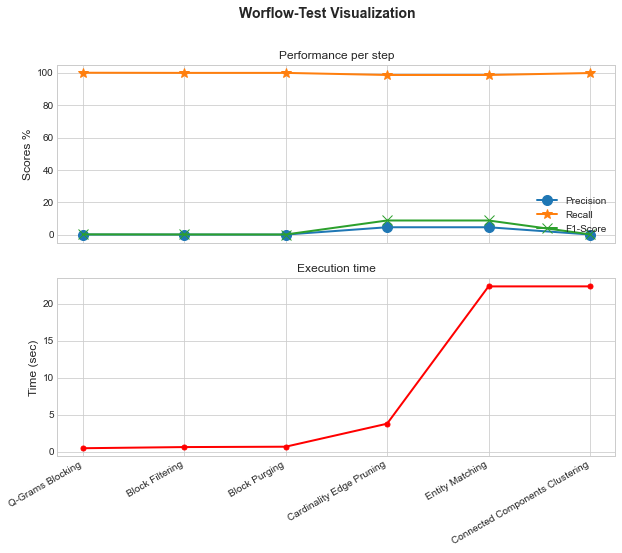

In [8]:
w.visualize()

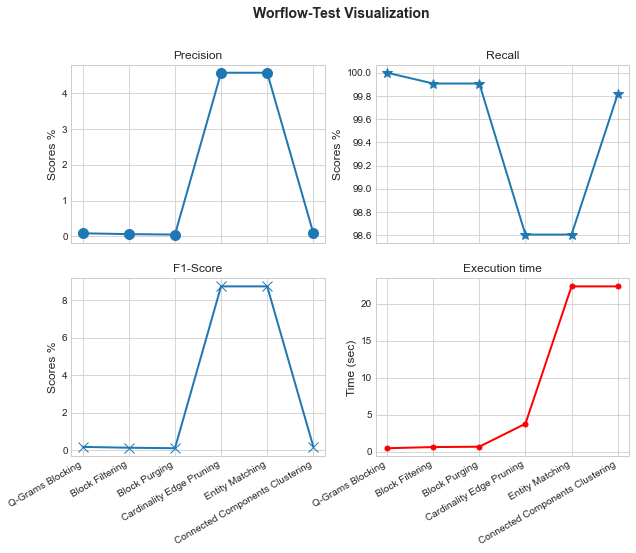

In [9]:
w.visualize(separate=True)

## Multiple workflows - Comparison

In [10]:
w1 = WorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=4),
        attributes_1=['name'],
        attributes_2=['name']
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.6)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
        entity_matching = dict(
        method=EntityMatching, 
        metric='sorensen_dice',
        similarity_threshold=0.5,
        attributes = ['description', 'name']
    ),
    clustering = dict(method=ConnectedComponentsClustering)
)
w1.run(data, verbose=False, workflow_tqdm_enable=True)
w2 = WorkFlow(
    block_building = dict(
        method=QGramsBlocking, 
        params=dict(qgrams=4),
        attributes_1=['name'],
        attributes_2=['name']
    ),
    block_cleaning = [
        dict(
            method=BlockFiltering, 
            params=dict(ratio=0.6)
        ),
        dict(
            method=BlockPurging, 
            params=dict(smoothing_factor=1.025)
        )
    ],
    comparison_cleaning = dict(method=CardinalityEdgePruning),
        entity_matching = dict(
        method=EntityMatching, 
        metric='sorensen_dice',
        similarity_threshold=0.6,
        attributes = ['description']
    ),
    clustering = dict(method=ConnectedComponentsClustering)
)
w2.run(data, verbose=False, workflow_tqdm_enable=True)

Workflow-1:   0%|          | 0/5 [00:00<?, ?it/s]

Workflow-2:   0%|          | 0/5 [00:00<?, ?it/s]

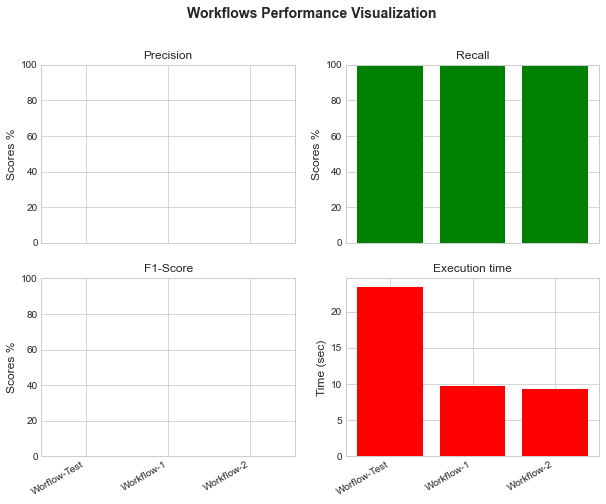

,Name,F1,Recall,Precision,Runtime (sec)
0,Worflow-Test,0.186095,99.814126,0.093134,23.436442
1,Workflow-1,0.193095,100.000000,0.096641,9.784822
2,Workflow-2,0.193095,100.000000,0.096641,9.284326


In [11]:
compare_workflows([w, w1, w2], with_visualization=True)